##Loading Image Data¶

In [ ]:
%matplotlib inline
import torch

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from torch import nn
from torch import optim
from torchvision import datasets, transforms, models


In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/data/cats_and_dogs/Cat_Dog_data"
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir+'/train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Visualize data

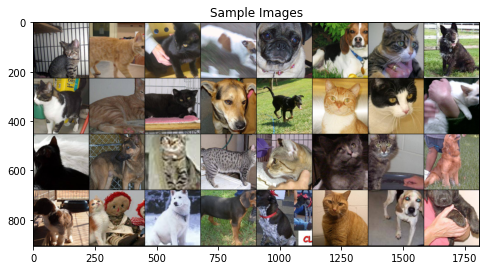

In [ ]:
images, labels = next(iter(dataloader))

plt.figure(figsize=(8,8))
plt.title("Sample Images")
plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Data augmentation

In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.2, 0.2, 0.2])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.2, 0.2, 0.2])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

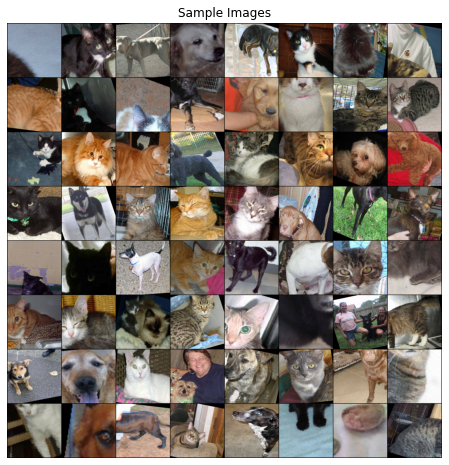

In [ ]:
data_iter = next(iter(train_loader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(vutils.make_grid(data_iter[0].to(device)[:64], padding=2, normalize=True).cpu(),(1, 2, 0)))

## Load and adapt pretrained model

In [ ]:
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(256, 2),
                                 nn.Softmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

## Finetuning

In [ ]:
epochs = 3
steps = 0
running_loss = 0
train_losses = []
test_losses = []
test_accuracies = []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        if steps == 10:
          break

        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        print_every = 5
        y_pred = model.forward(inputs)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    y_pred = model.forward(inputs)
                    batch_loss = criterion(y_pred, labels)
                    
                    test_loss += batch_loss.item()
                    
                    max_index = torch.argmax(y_pred, dim=1)
                    equals = (max_index == labels.view(*max_index.shape))
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            
            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(test_loader))
            test_accuracies.append(accuracy/len(test_loader))

            running_loss = 0
            model.train()


Epoch 1/3.. Train loss: 0.421.. Test loss: 0.336.. Test accuracy: 0.978
Epoch 2/3.. Train loss: 0.710.. Test loss: 0.333.. Test accuracy: 0.980
Epoch 2/3.. Train loss: 0.383.. Test loss: 0.341.. Test accuracy: 0.972
Epoch 2/3.. Train loss: 0.389.. Test loss: 0.333.. Test accuracy: 0.980
Epoch 2/3.. Train loss: 0.407.. Test loss: 0.334.. Test accuracy: 0.978
Epoch 2/3.. Train loss: 0.365.. Test loss: 0.331.. Test accuracy: 0.982
Epoch 2/3.. Train loss: 0.412.. Test loss: 0.339.. Test accuracy: 0.975
Epoch 2/3.. Train loss: 0.389.. Test loss: 0.350.. Test accuracy: 0.960
Epoch 2/3.. Train loss: 0.402.. Test loss: 0.331.. Test accuracy: 0.981
Epoch 2/3.. Train loss: 0.377.. Test loss: 0.330.. Test accuracy: 0.984
Epoch 2/3.. Train loss: 0.395.. Test loss: 0.345.. Test accuracy: 0.968
Epoch 2/3.. Train loss: 0.401.. Test loss: 0.334.. Test accuracy: 0.980
Epoch 2/3.. Train loss: 0.410.. Test loss: 0.329.. Test accuracy: 0.983
Epoch 2/3.. Train loss: 0.386.. Test loss: 0.331.. Test accuracy

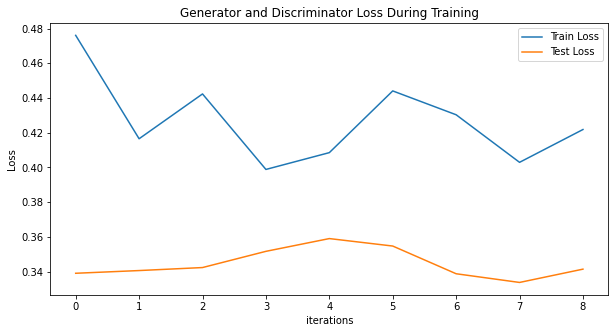

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train_losses,label="Train Loss")
plt.plot(test_losses,label="Test Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()